In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("/content/UK_foods.csv", index_col= "Unnamed: 0")

In [6]:
df.columns

Index(['England', 'Wales', 'Scotland', 'N.Ireland'], dtype='object')

In [7]:
df

,England,Wales,Scotland,N.Ireland
Cheese,105,103,103,66
Carcass_meat,245,227,242,267
Other_meat,685,803,750,586
Fish,147,160,122,93
Fats_and_oils,193,235,184,209
Sugars,156,175,147,139
Fresh_potatoes,720,874,566,1033
Fresh_Veg,253,265,171,143
Other_Veg,488,570,418,355
Processed_potatoes,198,203,220,187


### Data EDA

In [8]:
data = df.T

In [9]:
data

,Cheese,Carcass_meat,Other_meat,Fish,Fats_and_oils,Sugars,Fresh_potatoes,Fresh_Veg,Other_Veg,Processed_potatoes,Processed_Veg,Fresh_fruit,Cereals,Beverages,Soft_drinks,Alcoholic_drinks,Confectionery
England,105,245,685,147,193,156,720,253,488,198,360,1102,1472,57,1374,375,54
Wales,103,227,803,160,235,175,874,265,570,203,365,1137,1582,73,1256,475,64
Scotland,103,242,750,122,184,147,566,171,418,220,337,957,1462,53,1572,458,62
N.Ireland,66,267,586,93,209,139,1033,143,355,187,334,674,1494,47,1506,135,41


In [10]:
data.shape
#(4,17) implies 4 different countries and 17 ifferent food_items

(4, 17)

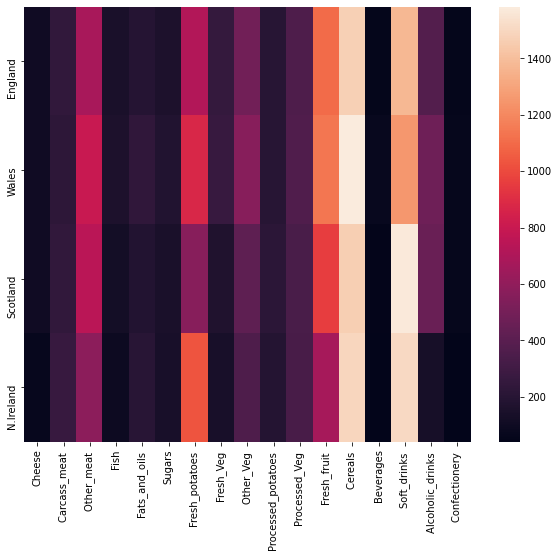

In [13]:
plt.subplots(figsize = (10,8))
sns.heatmap(data)
plt.show()

### Distance Technique

In [16]:
data.index

Index(['England', 'Wales', 'Scotland', 'N.Ireland'], dtype='object')

In [17]:
eng_vec = data.loc["England"].values
wales_vec = data.loc["Wales"].values
scot_vec = data.loc["Scotland"].values
ire_vec = data.loc["N.Ireland"].values

In [46]:
def distance(vec1, vec2, dis_type = "L2", round_digits = 3):
  '''
  vec1: Vector Input1
  vec2: Vector Input2
  dis_type: "L1" or "L2" to mark whether Manhattan Distance or Euclidean Distance
  round_digits: Rounding of final results
  '''
  assert (eng_vec.shape == ire_vec.shape), "The vectors have a shpae mismatch"
  assert isinstance(dis_type, str), "Please enter either string L1 or L2 as input"
  assert isinstance(round_digits, int), "type(round_digits) must be integer"
  
  if dis_type == "L1":
    dist = np.sum(vec1 - vec2)

  if dis_type == "L2":
    dist = np.sum(np.square(vec1 - vec2))**0.5

  return np.round(dist, round_digits)

In [50]:
my_countries = ['England', 'Wales', 'Scotland', 'N.Ireland']
pair_lists = []
for i in range(len(my_countries)):
  for j in range(i+1, len(my_countries)):
    pair_lists.append((my_countries[i],my_countries[j]))

print(pair_lists)    #Getting all the pairs  

[('England', 'Wales'), ('England', 'Scotland'), ('England', 'N.Ireland'), ('Wales', 'Scotland'), ('Wales', 'N.Ireland'), ('Scotland', 'N.Ireland')]


In [52]:
my_dict = {"England": eng_vec,
           "Wales": wales_vec,
           "Scotland": scot_vec,
           "N.Ireland":ire_vec
           }

In [57]:
final_dict = {}
final_dict["pair"] = []
final_dict["value"] = []

for v1,v2 in pair_lists:
  d = distance(my_dict[v1],my_dict[v2])
  final_dict["pair"].append((v1,v2))
  final_dict["value"].append(d)

In [67]:
final_dict_df = pd.DataFrame(final_dict["value"], index = final_dict["pair"], columns= ["dist_value"])
final_dict_df

,dist_value
"(England, Wales)",291.179
"(England, Scotland)",329.660
"(England, N.Ireland)",634.652
"(Wales, Scotland)",532.061
"(Wales, N.Ireland)",738.610
"(Scotland, N.Ireland)",666.810


In [71]:
#Hard to justify which is distinct from others

### AE Route

In [72]:
data

,Cheese,Carcass_meat,Other_meat,Fish,Fats_and_oils,Sugars,Fresh_potatoes,Fresh_Veg,Other_Veg,Processed_potatoes,Processed_Veg,Fresh_fruit,Cereals,Beverages,Soft_drinks,Alcoholic_drinks,Confectionery
England,105,245,685,147,193,156,720,253,488,198,360,1102,1472,57,1374,375,54
Wales,103,227,803,160,235,175,874,265,570,203,365,1137,1582,73,1256,475,64
Scotland,103,242,750,122,184,147,566,171,418,220,337,957,1462,53,1572,458,62
N.Ireland,66,267,586,93,209,139,1033,143,355,187,334,674,1494,47,1506,135,41


In [73]:
#scaling data for NN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [74]:
data_scaled

array([[1.        , 0.45      , 0.4562212 , 0.80597015, 0.17647059,
        0.47222222, 0.32976445, 0.90163934, 0.61860465, 0.33333333,
        0.83870968, 0.92440605, 0.08333333, 0.38461538, 0.37341772,
        0.70588235, 0.56521739],
       [0.94871795, 0.        , 1.        , 1.        , 1.        ,
        1.        , 0.65952891, 1.        , 1.        , 0.48484848,
        1.        , 1.        , 1.        , 1.        , 0.        ,
        1.        , 1.        ],
       [0.94871795, 0.375     , 0.75576037, 0.43283582, 0.        ,
        0.22222222, 0.        , 0.2295082 , 0.29302326, 1.        ,
        0.09677419, 0.6112311 , 0.        , 0.23076923, 1.        ,
        0.95      , 0.91304348],
       [0.        , 1.        , 0.        , 0.        , 0.49019608,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.26666667, 0.        , 0.79113924,
        0.        , 0.        ]])

##### AutoEncoder Architecture

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [76]:
data_scaled.shape

(4, 17)

In [77]:
#Architecture Layout: 17---->8------>4------>2------>4------>8------->17

In [78]:
encoder = Sequential()
encoder.add(Dense(8, input_shape = [data_scaled.shape[1]], activation = "relu"))
encoder.add(Dense(4, activation = "relu"))
encoder.add(Dense(2, activation = "relu"))       #this layer will be the bridge between encoder & decoder architecture

In [79]:
decoder = Sequential()
decoder.add(Dense(4, input_shape = [2], activation ="relu"))
decoder.add(Dense(8, activation = "relu"))
decoder.add(Dense(17, activation = "relu"))

In [80]:
ae = Sequential([encoder, decoder])

In [81]:
ae.compile(loss = "mse", optimizer = "adam")

In [82]:
ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 190       
_________________________________________________________________
sequential_1 (Sequential)    (None, 17)                205       
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


In [84]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 144       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


In [85]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 17)                153       
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [96]:
model_history = ae.fit(data_scaled, data_scaled, epochs = 15)

Epoch 1/15
1/1 [==============================] - 0s 4ms/step - loss: 0.4090
Epoch 2/15
1/1 [==============================] - 0s 3ms/step - loss: 0.4070
Epoch 3/15
1/1 [==============================] - 0s 5ms/step - loss: 0.4050
Epoch 4/15
1/1 [==============================] - 0s 5ms/step - loss: 0.4030
Epoch 5/15
1/1 [==============================] - 0s 4ms/step - loss: 0.4010
Epoch 6/15
1/1 [==============================] - 0s 5ms/step - loss: 0.3989
Epoch 7/15
1/1 [==============================] - 0s 4ms/step - loss: 0.3969
Epoch 8/15
1/1 [==============================] - 0s 4ms/step - loss: 0.3948
Epoch 9/15
1/1 [==============================] - 0s 6ms/step - loss: 0.3927
Epoch 10/15
1/1 [==============================] - 0s 4ms/step - loss: 0.3905
Epoch 11/15
1/1 [==============================] - 0s 4ms/step - loss: 0.3884
Epoch 12/15
1/1 [==============================] - 0s 4ms/step - loss: 0.3862
Epoch 13/15
1/1 [==============================] - 0s 4ms/step - loss: 0.

In [97]:
model_history_df = pd.DataFrame(model_history.history)

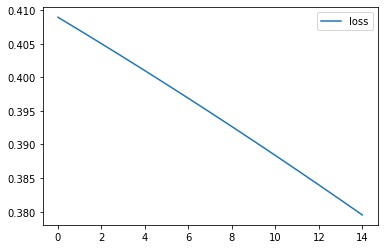

In [98]:
model_history_df.plot()

In [105]:
data_dim_reduced = encoder(data_scaled).numpy()

In [106]:
data_dim_reduced

array([[0.5454328 , 0.        ],
       [0.68896013, 0.        ],
       [0.4716747 , 0.        ],
       [0.06662679, 0.        ]], dtype=float32)

In [108]:
data_dim_reduced[0,0]

0.5454328

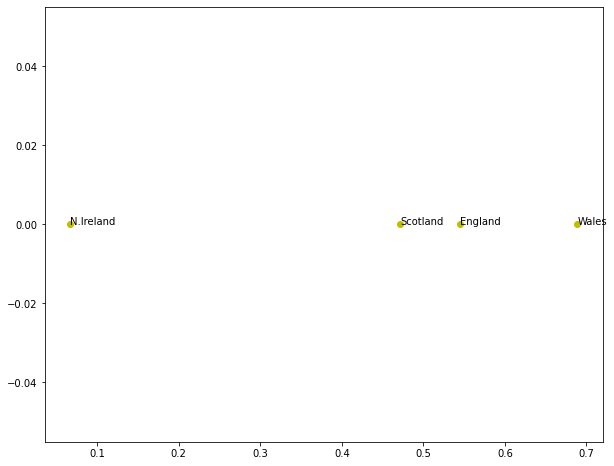

In [114]:
my_countries = ['England', 'Wales', 'Scotland', 'N.Ireland']

fig, ax = plt.subplots(figsize = (10,8)) 
ax.scatter(data_dim_reduced[:,0], data_dim_reduced[:,1] , c ="y")
for i in range(len(my_countries)):
  ax.annotate(my_countries[i] , (data_dim_reduced[ i,0] , data_dim_reduced[ i,1]))

plt.show()

In [116]:
# from the above picture, its clear that N.Ireland has different food consumption bahaviour compared to other countries in UK